In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/malawi-datasets/Dataset_Malawi_National_Football_Team_Matches.csv


 # Loading the data 

In [2]:
data = pd.read_csv("/kaggle/input/malawi-datasets/Dataset_Malawi_National_Football_Team_Matches.csv")

# Cleaning and Preprocessing 

In [3]:
# transform to Data Frame
data = pd.DataFrame(data)
data

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Date,Opponent,Team Score,Opponent Score,Result,Venue,Competition
0,~1957,Northern Rhodesia,0.0,5.0,Loss,Unknown,Friendly (First International)
1,~1962,Ghana,0.0,12.0,Loss,Unknown,Friendly
2,~1968,Botswana,8.0,1.0,Win,Unknown,Friendly
3,02/06/1996,South Africa,0.0,3.0,Loss,Away,World Cup Qualifier
4,07/07/1996,Zambia,1.0,1.0,Draw,Home,Friendly
...,...,...,...,...,...,...,...
68,14/11/2024,Burundi,0.0,0.0,Draw,Home,AFCON 2025 Qualifier
69,18/11/2024,Burkina Faso,0.0,1.0,Loss,Away,AFCON 2025 Qualifier
70,02/03/2025,Comoros,2.0,0.0,Win,Away,Friendly
71,20/03/2025,Namibia,0.0,1.0,Loss,Away,World Cup Qualifier


### Inspecting the data quickly

In [4]:
columns = ["Team Score", "Opponent Score", "Opponent", "Competition", "Venue", "Result"]

for col in columns:
    print(f"{col}: {len(data[col].value_counts())}")

Team Score: 6
Opponent Score: 7
Opponent: 36
Competition: 12
Venue: 3
Result: 4


In [5]:
# Preprocessing the Date column

print("Data Frame before changing the dates" ,data["Date"])
print("")

# Convert the 'Date' column to datetime format
data["Date"] = pd.to_datetime(data["Date"], errors='coerce', format = "%d/%m/%Y")


# Fill upp the missing values with correct year but random days and months 
data.loc[0, "Date"] = pd.to_datetime("01/01/1957", format="%d/%m/%Y")
data.loc[1, "Date"] = pd.to_datetime("01/01/1962", format="%d/%m/%Y")
data.loc[2, "Date"] = pd.to_datetime("01/01/1968", format="%d/%m/%Y")

print("Data Frame after changing the dates" ,data["Date"])

Data Frame before changing the dates 0          ~1957
1          ~1962
2          ~1968
3     02/06/1996
4     07/07/1996
         ...    
68    14/11/2024
69    18/11/2024
70    02/03/2025
71    20/03/2025
72    24/03/2025
Name: Date, Length: 73, dtype: object

Data Frame after changing the dates 0    1957-01-01
1    1962-01-01
2    1968-01-01
3    1996-06-02
4    1996-07-07
        ...    
68   2024-11-14
69   2024-11-18
70   2025-03-02
71   2025-03-20
72   2025-03-24
Name: Date, Length: 73, dtype: datetime64[ns]


### Removing the **latest match row** from the data set to try to predict the outcome later when we have our model

In [6]:
latest_match = data.loc[72, :]
print(latest_match)
print("")
data = data.drop(72)
print(data)

Date              2025-03-24 00:00:00
Opponent                      Tunisia
Team Score                        NaN
Opponent Score                    NaN
Result                            TBD
Venue                            Away
Competition       World Cup Qualifier
Name: 72, dtype: object

         Date           Opponent  Team Score  Opponent Score Result    Venue  \
0  1957-01-01  Northern Rhodesia         0.0             5.0   Loss  Unknown   
1  1962-01-01              Ghana         0.0            12.0   Loss  Unknown   
2  1968-01-01           Botswana         8.0             1.0    Win  Unknown   
3  1996-06-02       South Africa         0.0             3.0   Loss     Away   
4  1996-07-07             Zambia         1.0             1.0   Draw     Home   
..        ...                ...         ...             ...    ...      ...   
67 2024-10-11            Senegal         0.0             4.0   Loss     Away   
68 2024-11-14            Burundi         0.0             0.0   Draw  

# Make Predictions

### Get features and make a target variable then split the data in training and test set

In [7]:
# For the predictor, we will attempt to predict whether Malawi wins a match.

# Rows in Result column with win value (case and space insensitive) become 1, everythig else 0
data["Win"] = data["Result"].apply(lambda x : 1 if x.strip().lower() == "win" else 0)

# chose features
# use one hot encoding 
# pd.get_dummies() creates binary columns for each category in your specified features list.
# drop_first=True avoids dummy variable trap by dropping the first category in each column. 
    # Helpful when you're using models that assume independent variables (e.g., logistic regression).
features = ["Opponent", "Venue", "Competition"]
data_encoded = pd.get_dummies(data[features], drop_first=True)

target = data["Win"]

# Splitting data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_encoded, target, test_size=0.2, random_state=43)



## RandomForestClassifier

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Iniciate, fit and predict
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

# Check models accuracy on predicting test data
print("Accuracy:", accuracy_score(y_test, y_pred_rf))

Accuracy: 0.9333333333333333


### Evaluating the model with classification metrics to get a better insight on models performance 

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.50      0.67         2

    accuracy                           0.93        15
   macro avg       0.96      0.75      0.81        15
weighted avg       0.94      0.93      0.92        15

[[13  0]
 [ 1  1]]


### Visualizing Evaluations

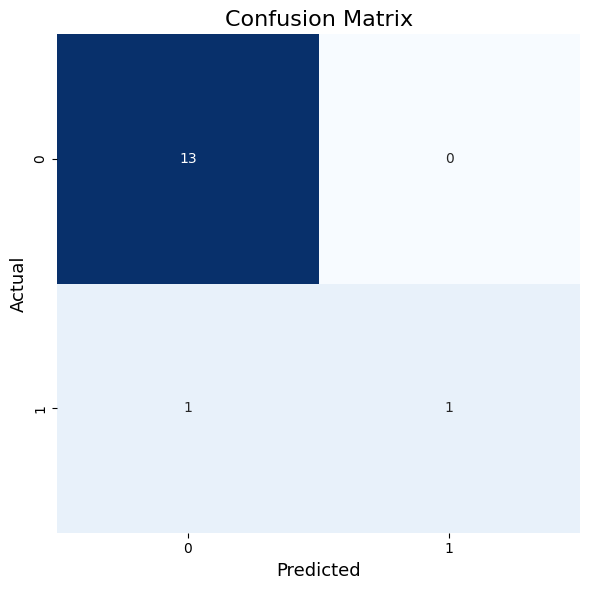

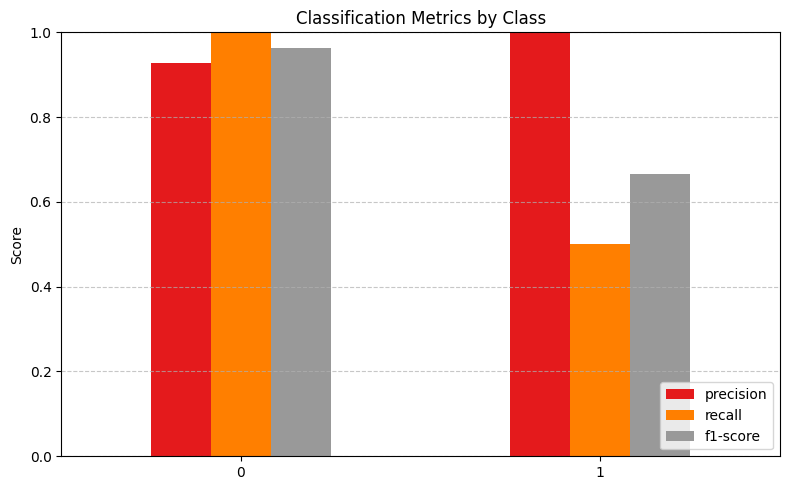

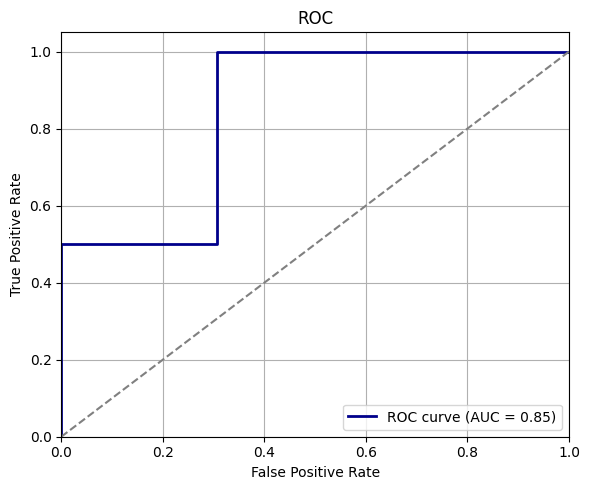

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix using seaborn
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['0', '1'],
            yticklabels=['0', '1'])
plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted", fontsize=13)
plt.ylabel("Actual", fontsize=13)
plt.tight_layout()
plt.show()


## Classification metrics ##
report = classification_report(y_test, y_pred_rf, output_dict=True)
metrics_df = pd.DataFrame(report).transpose()

# Plot precision, recall, and f1-score for each class
metrics_df = metrics_df.loc[['0', '1'], ['precision', 'recall', 'f1-score']]

metrics_df.plot(kind='bar', figsize=(8, 5), colormap='Set1')
plt.title("Classification Metrics by Class")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Make sure y_test and y_pred_rf are numpy arrays
y_test_array = np.array(y_test)
y_scores = model_rf.predict_proba(X_test)[:, 1]  # get probability estimates

# ROC Curve for binary classification
fpr, tpr, thresholds = roc_curve(y_test_array, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='darkblue', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# Let's predict the outcome of the latest match 
##### **The match have been played and the result was 0-1. Malawi lost against Tunisia. Let's see what the model says**

In [11]:
# Check the format to understand how to proceed further
print(latest_match.info())

<class 'pandas.core.series.Series'>
Index: 7 entries, Date to Competition
Series name: 72
Non-Null Count  Dtype 
--------------  ----- 
5 non-null      object
dtypes: object(1)
memory usage: 412.0+ bytes
None


In [12]:
# Transpose to make features columns instead of index
latest_match_df = latest_match.to_frame().T

In [13]:
latest_match_df

,Date,Opponent,Team Score,Opponent Score,Result,Venue,Competition
72,2025-03-24 00:00:00,Tunisia,NaN,NaN,TBD,Away,World Cup Qualifier


In [14]:
# Encoding the same way we did while training out model
# Result: You get new columns like Opponent_Tunisia, Venue_Away, Competition_World Cup Qualifier, etc., with True/False values.
latest_match_features = ["Opponent", "Venue", "Competition"]
match_enc = pd.get_dummies(latest_match_df[latest_match_features])

# Convert True/False to 1/0
# cast the encoded features to integers:
match_enc = match_enc.astype(int) 

# Align encoded columns to match training datn
# Reindex to match training columns, fill missing with 0
match_enc = match_enc.reindex(columns=data_encoded.columns, fill_value=0)

##### If a column like Competition_AFCON Qualifier was in training but not in the current match it gets added with a value of 0.

##### If the current match has a new category not seen during training (e.g., Opponent_SomeNewTeam), it gets dropped.

##### This is critical for compatibility with the model, which was trained on data_encoded.columns

In [15]:
match_enc

,Opponent_Angola,Opponent_Bangladesh,Opponent_Botswana,Opponent_Burkina Faso,Opponent_Burundi,Opponent_Cameroon,Opponent_Chad,Opponent_Comoros,Opponent_Cote d'Ivoire,Opponent_Egypt,...,Competition_AFCON 2021 Round of 16,Competition_AFCON 2025 Qualifier,Competition_AFCON Qualifier,Competition_AFCON Qualifier (Qualified),Competition_CHAN Qualifier,Competition_COSAFA Cup,Competition_Four Nations Tournament,Competition_Friendly,Competition_Friendly (First International),Competition_World Cup Qualifier
72,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [16]:
# Make a prediction with our RFC model
latest_match_prediction = model_rf.predict(match_enc)
print("Predicted outcome:", latest_match_prediction[0]) 

Predicted outcome: 0


##### **model_rf.predict(match_enc)** returns a NumPy array of predictions.
##### Since I am predicting one match, this array will have one element, [1] or [0].
##### **latest_match_prediction[0]** extracts that single predicted value.

# *Conclusion*
#### Earlier in the code we used lambda function **data["Win"] = data["Result"].apply(lambda x : 1 if x.strip().lower() == "win" else 0)** 
#### That means a win is marked as "1" and loss as "0". 
#### Since the match ended up 0:1 and Malawi took a loss, the model predicted the outcome correct. 